In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import scanpy.external as sce
import sys

import random
random.seed(10)
print(random.random()) 
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

sc.settings.set_figure_params(dpi=80)
%matplotlib inline 
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
sc.set_figure_params(scanpy=True, fontsize=14 )
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']

0.5714025946899135
-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                         9.4.0
asttokens                   NA
backcall                    0.2.0
cffi                        1.15.1
cloudpickle                 3.0.0
colorama                    0.4.6
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.12.3
dask                        2023.5.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
h5py                        3.8.0
igraph                      0.10.1
ipykernel                   6.15.2
ipython_genutils            0.2.0
ipywidgets                  7.6.5
jedi                        0.18.1
jinja2                      3.0.3
joblib                      1.2.0
jupyter_server              1.18.1
kiwisolver                  1.4.4
leidenalg                   0.9.1
llvmlite     

In [2]:
def refine_cluster(adata4, cluster_id, n_neighbors=10, n_pcs=30, resolution=0.1):
    """
    Re-cluster cells from a given cluster_id and update adata.obs['leiden_refined'].
    """
    # Subset
    cells = adata4[adata4.obs["leiden"] == cluster_id].copy()

    # Reclustering
    sc.pp.neighbors(cells, n_neighbors=n_neighbors, n_pcs=n_pcs)
    sc.tl.umap(cells)
    sc.tl.leiden(cells, resolution=resolution)

    # Make sure column exists
    if "leiden_refined" not in adata.obs:
        adata4.obs["leiden_refined"] = adata4.obs["leiden"].copy()

    # Add new categories
    new_labels = [f"{cluster_id}_{x}" for x in cells.obs["leiden"].unique()]
    adata.obs["leiden_refined"] = adata.obs["leiden_refined"].astype("category")
    adata.obs["leiden_refined"] = adata4.obs["leiden_refined"].cat.add_categories(new_labels)

    # Replace labels
    for idx, val in cells.obs["leiden"].items():
        adata4.obs.at[idx, "leiden_refined"] = f"{cluster_id}_{val}"

    return adata


In [3]:
def beautiful_cmap(initial_cmap="Reds", grey_intensity=0.2, color_intencity=0.1):
  
    from matplotlib import cm
    from matplotlib.colors import ListedColormap
    import numpy as np
    
    cm_color = cm.get_cmap(initial_cmap, 128)
    cm_grey = cm.get_cmap("Greys", 128)
    
    c = ListedColormap(
        np.vstack(
            (cm_grey(np.linspace(0.2, 0.2, 1)),
             cm_color(np.linspace(0.1, 1, 128)))
    ))
    
    return c

reds_cmap = beautiful_cmap()
blues_cmap = beautiful_cmap("Blues")
rb_cmap = beautiful_cmap("RdBu_r")


In [4]:
adata=sc.read_h5ad('epcam_clusters_annotation.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 42129 × 25865
    obs: 'plate', 'day', 'location', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'doublet_score', 'predicted_doublet', 'batch', 'leiden', 'leiden_refined', 'cluster_annotations'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_annotations', 'cluster_annotations_colors', 'day_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_refined_colors', 'location_colors', 'log1p', 'neighbors', 'pca', 'plate_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

/home/julia/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


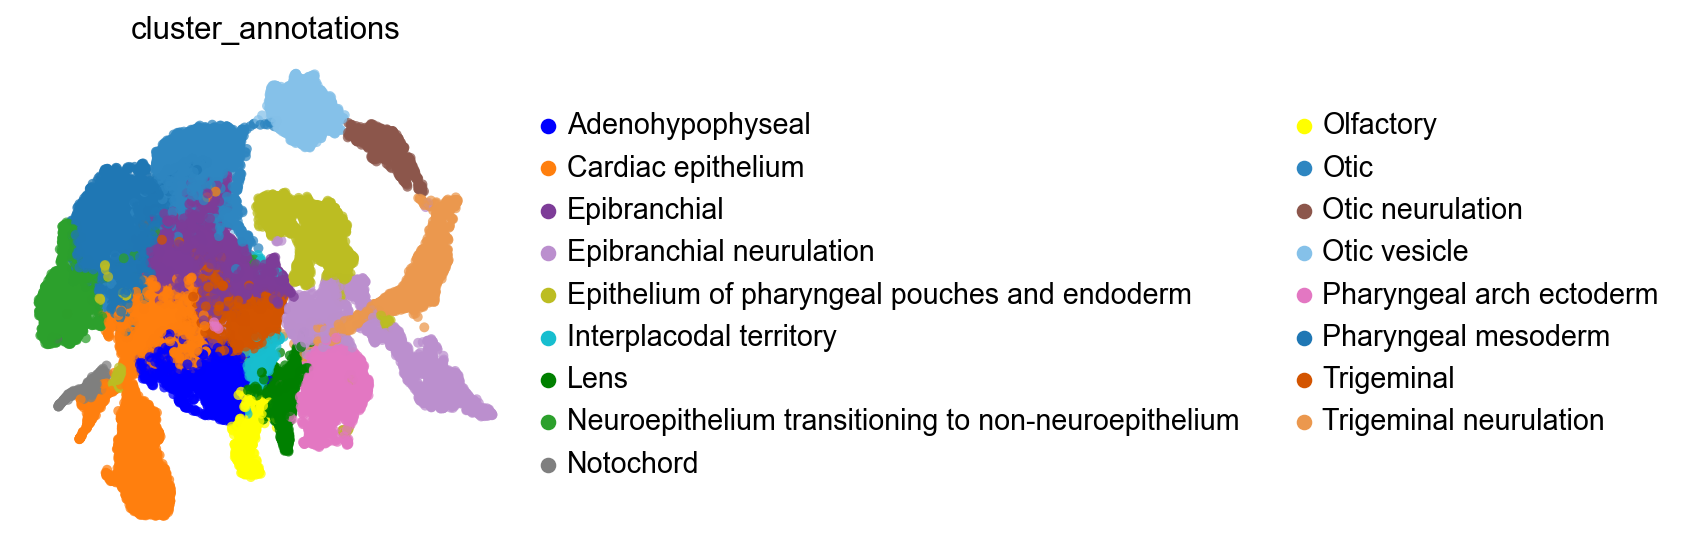

In [6]:
sc.pl.umap(adata, color = ["cluster_annotations"], color_map = reds_cmap, frameon = False, size = 80, alpha = .75)

In [7]:
gene_sets = {
    "signature_Otic": ["Oc90", "Pax2", "Sox10", "Lmx1a", "Tbx2"],
    "signature_Epibranchial": ["Pax8", "Shisa6", "Nrp1", "Fgf4", "Fgf3", "Fgf15"],
    "signature_Olfactory": ["Fezf1", "Vax1", "Dmrt3", "Nr2e1", 'Lhx2', 'Lrrc7'],
    "signature_Trigeminal": ["Pax3", "Wnt6", "Tfap2b"]
}


In [8]:
for name, genes in gene_sets.items():
    sc.tl.score_genes(adata, gene_list=genes, score_name=name)

computing score 'signature_Otic'
    finished: added
    'signature_Otic', score of gene set (adata.obs).
    200 total control genes are used. (0:00:02)
computing score 'signature_Epibranchial'
    finished: added
    'signature_Epibranchial', score of gene set (adata.obs).
    250 total control genes are used. (0:00:02)
computing score 'signature_Olfactory'
    finished: added
    'signature_Olfactory', score of gene set (adata.obs).
    199 total control genes are used. (0:00:02)
computing score 'signature_Trigeminal'
    finished: added
    'signature_Trigeminal', score of gene set (adata.obs).
    150 total control genes are used. (0:00:02)


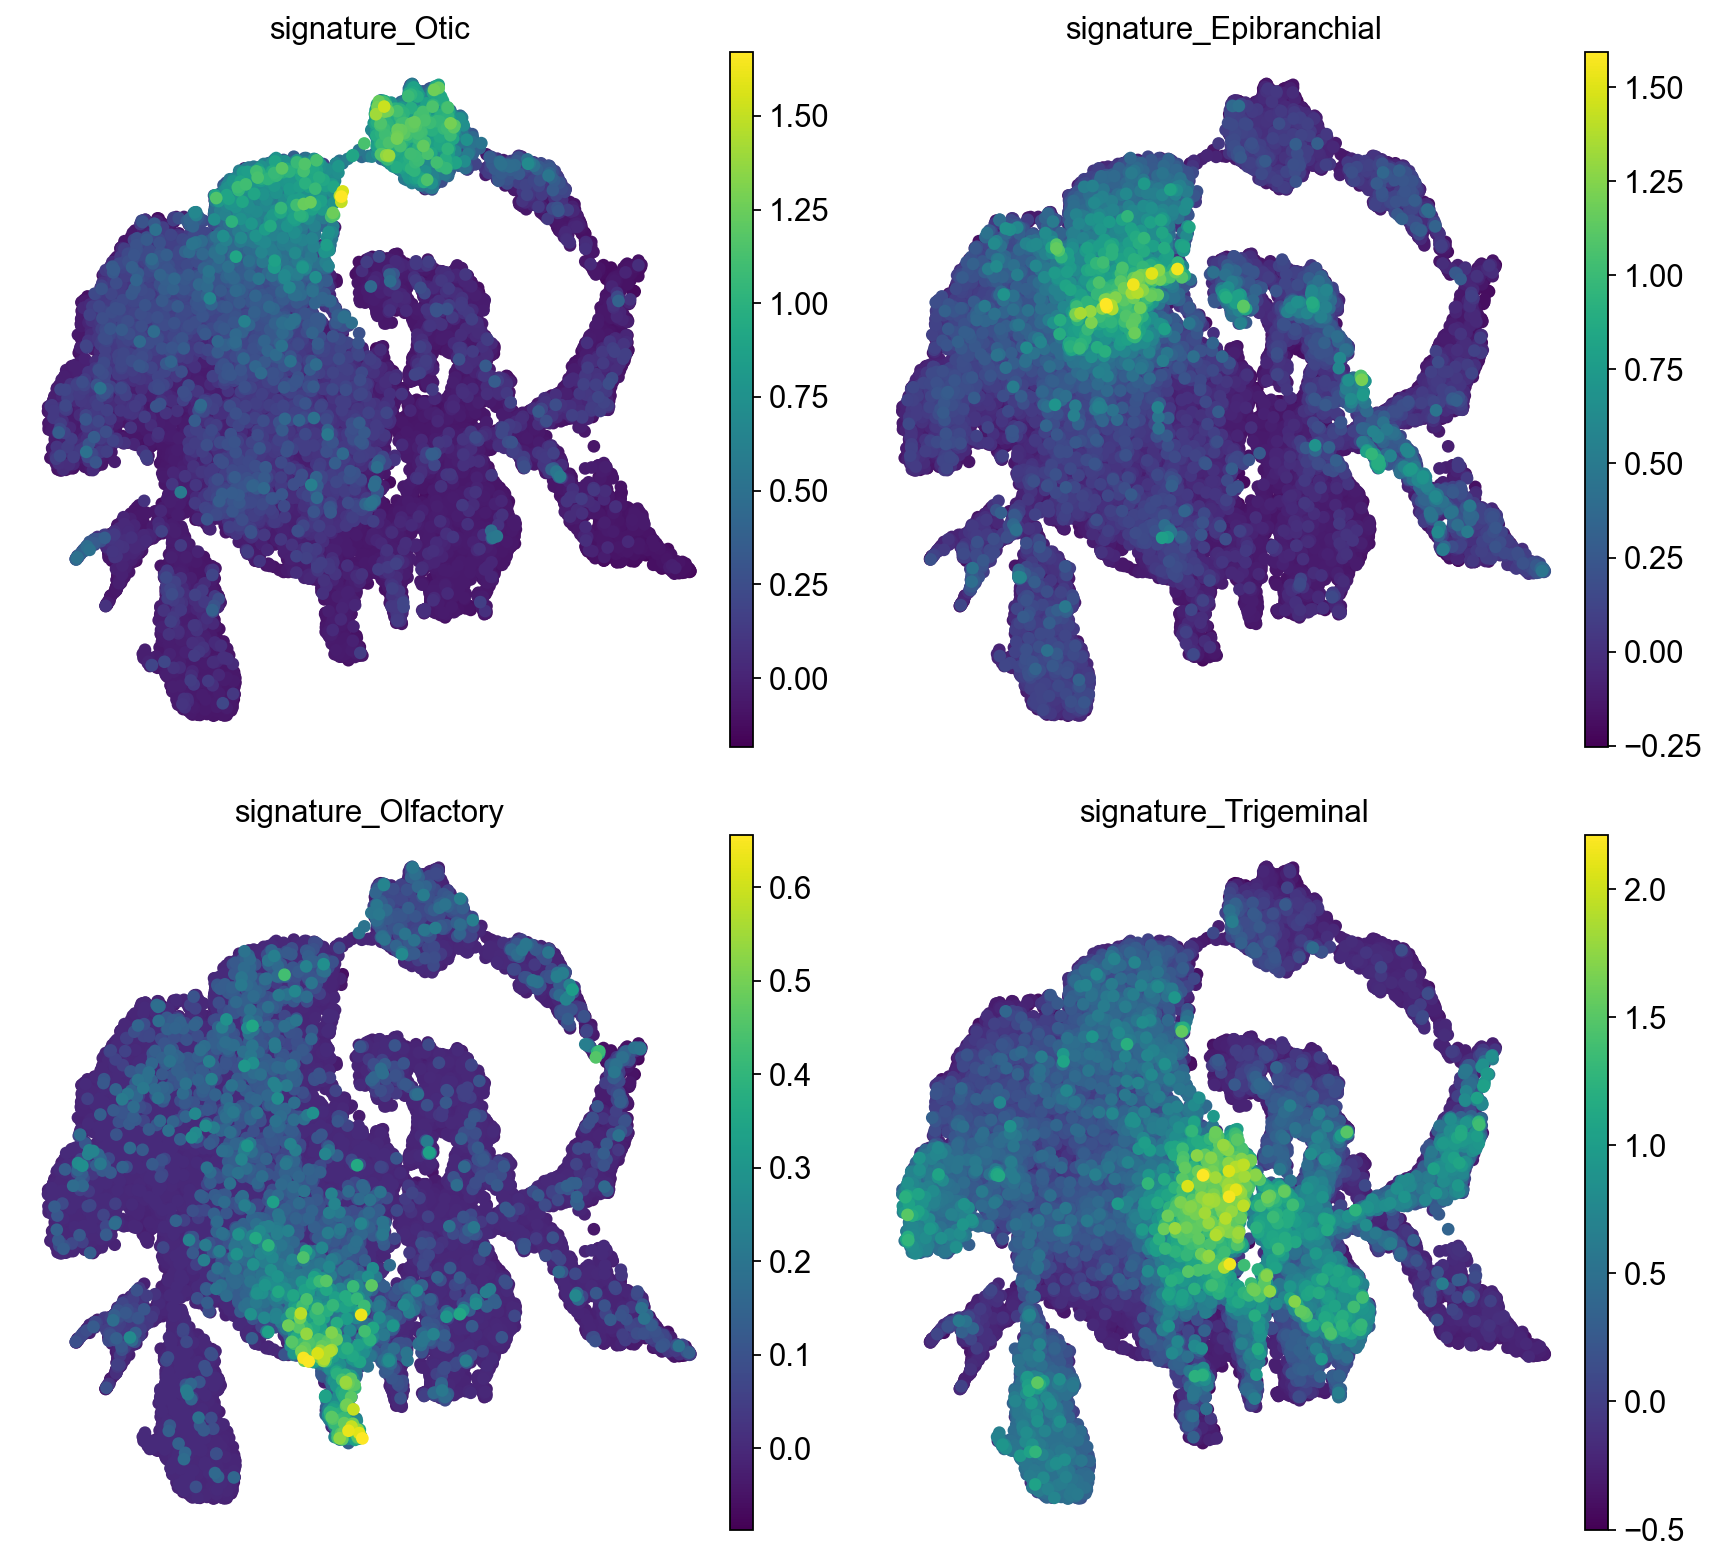

In [9]:
genes = list(gene_sets.keys())
n_genes = len(genes)

# Define grid layout (2 cols, as you wanted)
ncols = 2
nrows = int(np.ceil(n_genes / ncols))

fig, axs = plt.subplots(nrows, ncols, figsize=(11, 5*nrows))

axs = axs.flatten()

# Loop over each gene set
for i, gene in enumerate(genes):
    sc.pl.umap(
        adata,
        color=gene,
        frameon=False,
        ax=axs[i],
        show=False,
        size=130
    )

# Remove any empty subplot axes if n_genes is not a multiple of ncols
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.savefig("__umaps_all.svg", format="svg")
plt.show()


In [10]:
sigs = adata.obs[[ "signature_Trigeminal", "signature_Olfactory","signature_Otic", "signature_Epibranchial"]]

In [11]:
palette = {
    "signature_Otic": '#2e86c1',
    "signature_Epibranchial": '#7d3c98',
    "signature_Adenohypophyseal": "blue",
    "signature_Lens": "green",
    "signature_Olfactory": "yellow",
    "signature_Trigeminal": '#d35400',
    "rest": "lightgray"
}



/home/julia/miniconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


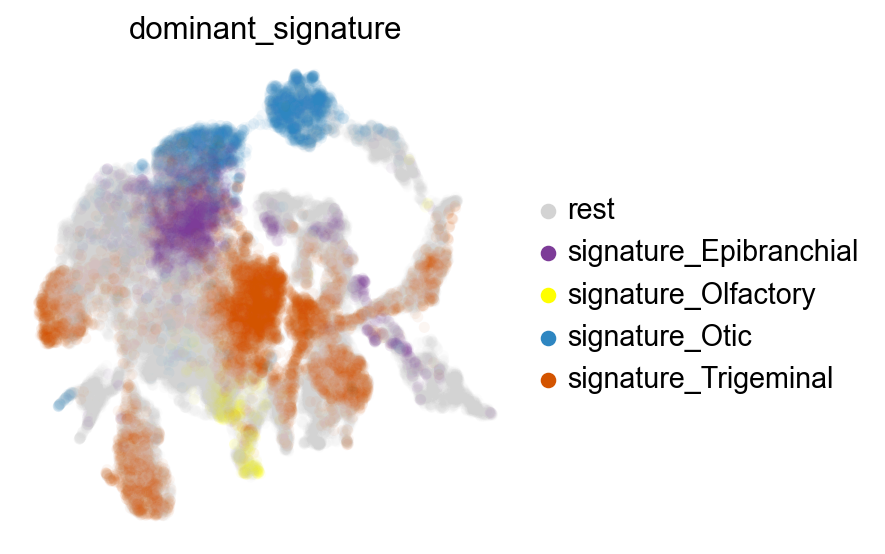

In [12]:
sigs = adata.obs[[k for k in gene_sets.keys()]]

# Find dominant signature + score
adata.obs["dominant_signature"] = sigs.idxmax(axis=1)
adata.obs["dominant_signature_score"] = sigs.max(axis=1)

# Apply a threshold → if max score < 0.1 (example), call it "rest"
threshold = 0.25
adata.obs.loc[adata.obs["dominant_signature_score"] < threshold, "dominant_signature"] = "rest"

# Make sure it's categorical for plotting
adata.obs["dominant_signature"] = adata.obs["dominant_signature"].astype("category")

# Plot with fixed palette
sc.pl.umap(
    adata,
    color="dominant_signature",
    palette=[palette[c] for c in adata.obs["dominant_signature"].cat.categories],
    frameon=False,
    size=100,alpha=0.05,
    legend_loc="right margin"
)


In [13]:
adata.write_h5ad('Epcam_signature.h5ad')